# Mission Analytics Data Excercise 

#### Code Authored by Kirtan Jani | kirtanjani97@gmail.com 

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression

### Data Pre-Processing

###### Here we will read in the dataset to a dataframe, clean some issues in the female data (delimited error), combine the male and female data by adding a gender column, and create new columns to help with answering our posed questions.

In [2]:
df_raw_males=pd.read_csv("MA_Exer_PikesPeak_Males.txt", sep="\t",encoding='ISO-8859-8')

In [3]:
df_raw_females=pd.read_csv("MA_Exer_PikesPeak_Females.txt", sep="\t", encoding='ISO-8859-8')

In [4]:
#make a copy of the dataset to not change original 
df_males=df_raw_males.copy(deep=True)
df_females=df_raw_females.copy(deep=True)

#insert gender column
df_males.insert(1,"Gender", "M")
df_females.insert(1, "Gender", "F")

In [5]:
#combine datasets into new dataframe
frames=[df_males, df_females]
df_combined = pd.concat(frames)

In [6]:
#rename columns and drop 4 rows that have terribly incomplete data
df_combined.columns=["Place", "Gender", "Div/Total", "Bib Number", "Name", "Age", "Hometown", "Gun_Time", "Net_Time", "Pace"]

df_combined = df_combined[df_combined['Age'].notna()]

In [7]:
#create new function that takes in timeseries data and converts it into seconds for ease of calculations
#create new columns and populate each cell using lambda function that calls our conversion function

def string2seconds(x):
    if len(x.split(':')) > 2:
        return (int(x.split(':')[0]) * 60 * 60) + (int(x.split(':')[1]) * 60) + int(x.split(':')[2])
    else:
        return int(x.split(':')[0]) * 60 + int(x.split(':')[1])

df_combined['Gun_Time_S'] = df_combined.apply(lambda f: string2seconds(f['Gun_Time']), axis=1)
df_combined['Net_Time_S'] = df_combined.apply(lambda f: string2seconds(f['Net_Time']), axis=1)


In [8]:
#create gender and age based divisions (groupings of runners) and create new column
def divisions(age, gender):
    
    if age <= 14:
        div = 0
    elif age <= 19:
        div = 1
    else:
        div = int(age/10)
        
    return '{} {}'.format(gender, str(div))

df_combined['New Division'] = df_combined.apply(lambda f: divisions(f['Age'], f['Gender']), axis=1)

In [9]:
df_combined.head()

,Place,Gender,Div/Total,Bib Number,Name,Age,Hometown,Gun_Time,Net_Time,Pace,Gun_Time_S,Net_Time_S,New Division
0,1,M,1/48,9,Joshua Kemei,22.0,Kenya .,28:48,28:47,4:38,1728,1727,M 2
1,2,M,2/48,35,George Kirwa Misoi,22.0,Kenya .,29:11,29:10,4:42,1751,1750,M 2
2,3,M,3/48,3,Jacob Frey,24.0,Oakton VA,29:38,29:37,4:46,1778,1777,M 2
3,4,M,1/96,49,Gurmessa Kumsa,27.0,Oxon Hill MD,29:46,29:46,4:48,1786,1786,M 2
4,5,M,4/48,31,Mike Baird,24.0,Ardmore PA,30:31,30:30,4:55,1831,1830,M 2


In [10]:
#creating two new columns to be able to update the div/total errors
df = pd.DataFrame(columns = df_combined.columns)
df['Rank'] = 0
df['Division Size'] = 0

#creating new dataframes
for division in range(0,9):
    df_division_m = df_combined.loc[df_combined['New Division']=="M {}".format(division)]
    df_division_m = df_division_m.sort_values(by = 'Net_Time_S')
    
    df_division_m['Rank'] = pd.RangeIndex(stop=df_division_m.shape[0]) + 1
    df_division_m['Division Size'] = len(df_division_m)
    
    df_division_f = df_combined.loc[df_combined['New Division']=="F {}".format(division)]
    df_division_f = df_division_f.sort_values(by = 'Net_Time_S')
    
    df_division_f['Rank'] = pd.RangeIndex(stop=df_division_f.shape[0]) + 1
    df_division_f['Division Size'] = len(df_division_f)
    
    frames = [df, df_division_m, df_division_f]
    df = pd.concat(frames)
    
def new_division(rank, size):
    return '{}/{}'.format(rank, size)

df['New Div/Total']=df.apply(lambda f: new_division(f['Rank'], f['Division Size']), axis=1)
    

In [11]:
df=df[['Place','New Div/Total','Name','Age','Gender','Gun_Time_S','Net_Time_S','New Division']]
df

,Place,New Div/Total,Name,Age,Gender,Gun_Time_S,Net_Time_S,New Division
158,159,1/29,Nicolas Escobar,14.0,M,2747,2530,M 0
216,217,2/29,Corey Danoff,13.0,M,2680,2617,M 0
342,343,3/29,Jeremy Ardanuy,12.0,M,2946,2765,M 0
384,385,4/29,Robbie Kane,14.0,M,3035,2816,M 0
400,401,5/29,Adam Rau,14.0,M,3054,2834,M 0
...,...,...,...,...,...,...,...,...
286,287,1/3,Margery Elliott,73.0,F,3155,3154,F 7
846,847,2/3,Betty Dameron,70.0,F,3859,3853,F 7
1052,1053,3/3,Jacquelin O'neil,74.0,F,4769,4533,F 7
1230,1231,1/2,Raymond Palfrey,81.0,M,4680,4376,M 8


### Q1

###### Here we will look at the mean, median, mode, and range of the race results for all racers by gender (*calculated using net time*).

In [12]:
dfm=df.loc[df['Gender']=="M"]
dff=df.loc[df['Gender']=='F']

In [13]:
'Mean : Males - {} | Females - {}'.format(dfm['Net_Time_S'].mean(),dff['Net_Time_S'].mean())

'Mean : Males - 3127.9129746835442 | Females - 3507.88134057971'

In [14]:
'Median: Males - {} | Females - {}'.format(dfm['Net_Time_S'].median(),dff['Net_Time_S'].median())

'Median: Males - 3082.5 | Females - 3470.0'

In [15]:
'Range : Males - {} | Females - {}'.format((dfm['Net_Time_S'].max() - dfm['Net_Time_S'].min()), (dff['Net_Time_S'].max() - dff['Net_Time_S'].min()))

'Range : Males - 4311 | Females - 4431'

In [16]:
#Only take first result (2128) for MALES MODE
dfm['Net_Time_S'].mode()

0    2128
1    2825
2    2843
3    2988
4    2998
5    3080
6    3126
7    3162
8    3264
9    3403
dtype: object

In [17]:
#Only take first result (2886) for FEMALES MODE
dff['Net_Time_S'].mode()

0    2886
1    3095
2    3179
3    3209
4    3540
dtype: object

### Q2

###### Here we will analyze the difference between gun and net time race results.

In [18]:
#created a copy of of dataframe to be able to manipulate the dataframe specifically for Q2
dfq2 = df.copy()

In [19]:
#checkiing succesful creation of copy
dfq2

,Place,New Div/Total,Name,Age,Gender,Gun_Time_S,Net_Time_S,New Division
158,159,1/29,Nicolas Escobar,14.0,M,2747,2530,M 0
216,217,2/29,Corey Danoff,13.0,M,2680,2617,M 0
342,343,3/29,Jeremy Ardanuy,12.0,M,2946,2765,M 0
384,385,4/29,Robbie Kane,14.0,M,3035,2816,M 0
400,401,5/29,Adam Rau,14.0,M,3054,2834,M 0
...,...,...,...,...,...,...,...,...
286,287,1/3,Margery Elliott,73.0,F,3155,3154,F 7
846,847,2/3,Betty Dameron,70.0,F,3859,3853,F 7
1052,1053,3/3,Jacquelin O'neil,74.0,F,4769,4533,F 7
1230,1231,1/2,Raymond Palfrey,81.0,M,4680,4376,M 8


In [20]:
#creating new column 'Abs_Time' absolute time between official race start and runner race start
dfq2['Abs_Time']=(dfq2['Gun_Time_S']-dfq2['Net_Time_S']).abs()

In [21]:
#creating new columns of divisions minus gender (age based ONLY). Then converting to numeric
def divisionsNOgender(x):
        return str.split(x)[1]
dfq2['NewDivision_NoGender'] = dfq2.apply(lambda f: divisionsNOgender(f['New Division']), axis=1)

dfq2['NewDivision_NoGender']=dfq2['NewDivision_NoGender'].apply(pd.to_numeric)

In [22]:
#checking creation success
dfq2.head(3)

,Place,New Div/Total,Name,Age,Gender,Gun_Time_S,Net_Time_S,New Division,Abs_Time,NewDivision_NoGender
158,159,1/29,Nicolas Escobar,14.0,M,2747,2530,M 0,217,0
216,217,2/29,Corey Danoff,13.0,M,2680,2617,M 0,63,0
342,343,3/29,Jeremy Ardanuy,12.0,M,2946,2765,M 0,181,0


<Figure size 504x504 with 0 Axes>

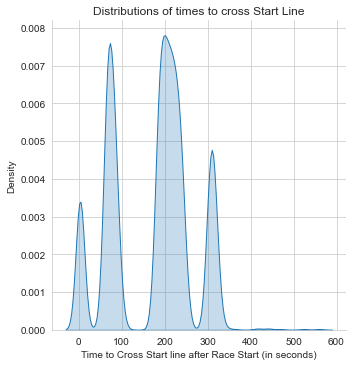

<Figure size 504x504 with 0 Axes>

In [23]:
#defining 'w' as dataframe variable with dtype float 
w=dfq2['Abs_Time'].astype(float)

#creating density plot
sns.set_style('whitegrid')
sns.displot(w, kind="kde",bw_adjust=.5,fill=True)
plt.title('Distributions of times to cross Start Line')
plt.xlabel('Time to Cross Start line after Race Start (in seconds)')
plt.figure(figsize=(7,7))

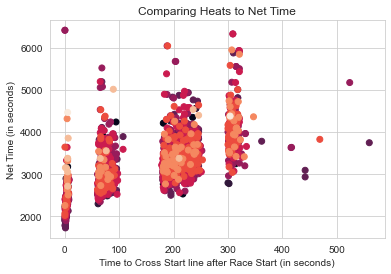

<Figure size 504x504 with 0 Axes>

In [24]:
#creating scatter plot to visualize waves of runners compared to net time
x=dfq2['Abs_Time']
y=dfq2['Net_Time_S']
z=dfq2['NewDivision_NoGender']
plt.title('Comparing Heats to Net Time')
plt.xlabel('Time to Cross Start line after Race Start (in seconds)')
plt.ylabel('Net Time (in seconds)')
plt.scatter(x, y, c=z)

plt.figure(figsize=(7,7))
plt.show()

### Q3

###### Here we find much time separates Chris Doe from the top 10 percentile of racers of the same division.

In [25]:
#locate Chris Doe
df.loc[df['Name']=="Chris Doe"]

,Place,New Div/Total,Name,Age,Gender,Gun_Time_S,Net_Time_S,New Division
534,535,189/415,Chris Doe,44.0,M,3187,2983,M 4


In [26]:
#identify the rest of the division that Chris is in: M4 (Males Fourth Division)
df.loc[df['New Division']=="M 4"]

,Place,New Div/Total,Name,Age,Gender,Gun_Time_S,Net_Time_S,New Division
14,15,1/415,Mark Malander,48.0,M,1987,1986,M 4
21,22,2/415,Darrell General,40.0,M,2043,2042,M 4
22,23,3/415,David Haaga,44.0,M,2051,2050,M 4
24,25,4/415,George Buckheit,48.0,M,2065,2063,M 4
30,31,5/415,Derik Thomas,40.0,M,2082,2081,M 4
...,...,...,...,...,...,...,...,...
1253,1254,411/415,Byung Lee,48.0,M,5076,4893,M 4
1258,1259,412/415,Kenape Gogo,41.0,M,5258,5193,M 4
1259,1260,413/415,Neil Gilliam,40.0,M,5564,5377,M 4
1260,1261,414/415,Kenneth Winkfield,49.0,M,5750,5429,M 4


In [27]:
#locate the 90th percentile and subtract Chris Doe's time (TIME TO ENTER TOP 10th)
x=df.loc[df['New Division']=="M 4"]['Net_Time_S'].quantile(.10)
'Time Needed for Chris Doe to break into top 10th percentile - {}'.format((np.abs(np.floor(x)-2983)))

'Time Needed for Chris Doe to break into top 10th percentile - 482.0'

In [28]:
x1=(df.loc[df['New Division']=="M 4"]['Net_Time_S']).astype(float)
x2=df.loc[df['New Division']=="M 4"]['Net_Time_S'].quantile(.10)
x3=df.loc[df['New Division']=="M 4"]['Net_Time_S'].mean()

'Top 10th percentile - {} | M4 mean - {}'.format(x2,x3)

'Top 10th percentile - 2501.4 | M4 mean - 3096.3012048192772'

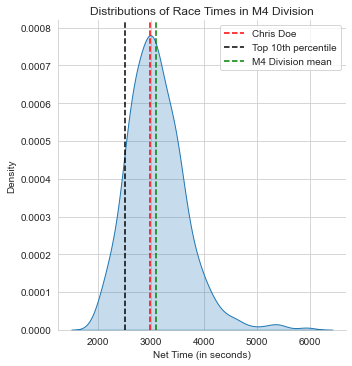

<Figure size 504x504 with 0 Axes>

In [29]:
#creating density plot
sns.set_style('whitegrid')

sns.displot(x1, kind="kde",bw_adjust=1,fill=True)
plt.title('Distributions of Race Times in M4 Division')
plt.xlabel('Net Time (in seconds)')
plt.axvline(x=2983, c='r', linestyle ='--',label ='Chris Doe')
plt.axvline(x=x2, c='k',linestyle='--',label ='Top 10th percentile')
plt.axvline(x=x3, c='g',linestyle='--',label ='M4 Division mean')
plt.legend()

plt.figure(figsize=(7,7))
plt.show()

### Q4

###### Here we compare the race results of each division.

In [30]:
#checking original df
df.head()

,Place,New Div/Total,Name,Age,Gender,Gun_Time_S,Net_Time_S,New Division
158,159,1/29,Nicolas Escobar,14.0,M,2747,2530,M 0
216,217,2/29,Corey Danoff,13.0,M,2680,2617,M 0
342,343,3/29,Jeremy Ardanuy,12.0,M,2946,2765,M 0
384,385,4/29,Robbie Kane,14.0,M,3035,2816,M 0
400,401,5/29,Adam Rau,14.0,M,3054,2834,M 0


In [31]:
#define function to plot density graphs of the same male and female division to compare results of each div.
def divdensity (x,y):
    a=df.loc[df['New Division']==x]['Net_Time_S'].astype(float)
    b=df.loc[df['New Division']==y]['Net_Time_S'].astype(float)
    c=df.loc[df['New Division']==x]['Net_Time_S'].mean()
    d=df.loc[df['New Division']==y]['Net_Time_S'].mean()
    
    sns.set_style('whitegrid')

    sns.kdeplot(a,bw_adjust=1,fill=True, label= (x + " Div"))
    plt.axvline(c, c='b', linestyle ='--',label = (x + " Div Mean"))
    sns.kdeplot(b,bw_adjust=1,fill=True, label = (y + " Div"))
    plt.axvline(d, c='r',linestyle='--',label = (y + " Div Mean"))
    plt.legend()

    plt.xlabel('Net Time (in seconds)')
    plt.figure(figsize=(7,7))
    plt.show()
    
    return

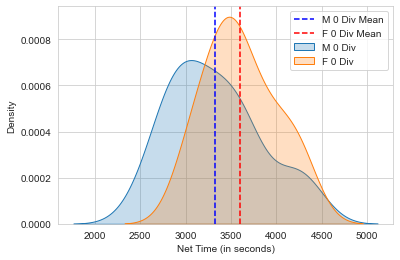

<Figure size 504x504 with 0 Axes>

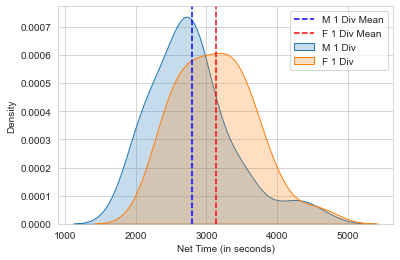

<Figure size 504x504 with 0 Axes>

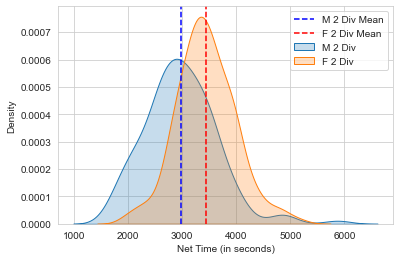

<Figure size 504x504 with 0 Axes>

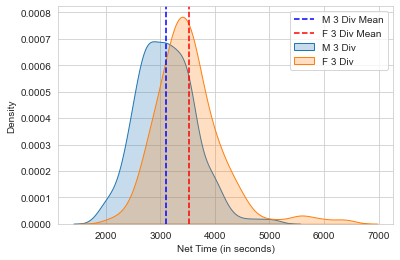

<Figure size 504x504 with 0 Axes>

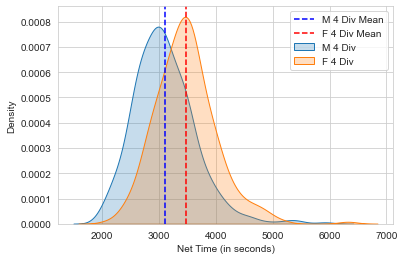

<Figure size 504x504 with 0 Axes>

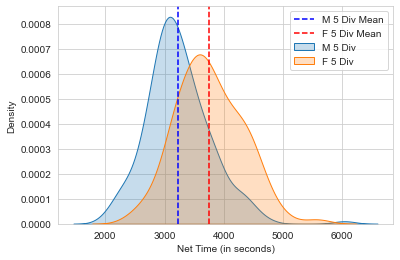

<Figure size 504x504 with 0 Axes>

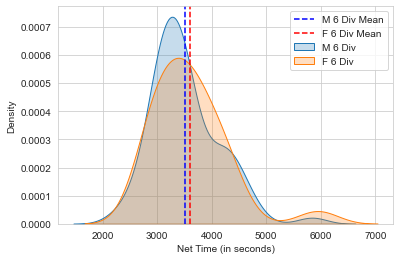

<Figure size 504x504 with 0 Axes>

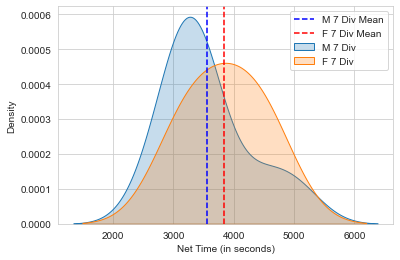

<Figure size 504x504 with 0 Axes>

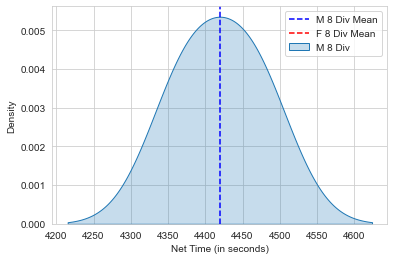

<Figure size 504x504 with 0 Axes>

In [32]:
for i in range(0,9):
               
    divdensity('M'+" " + str(i), "F"+" " + str(i))

### END OF CODE
###### Time to complete excercise: aprox 1hr and 30 mins.
###### Thank you for the opportunity to participate in this excercise. I had a great time.